In [6]:
import sys, os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from time import sleep

from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D, MaxPool2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.utils import np_utils
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [7]:
trainDataDir = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/Training'
validationDataDir = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/PublicTest'
testDataDir = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/PrivateTest'

In [8]:
dataLabels = {
    "Angry": 0, "Disgust": 1, "Fear": 2, "Happy": 3, "Sad": 4, "Surprise": 5, "Neutral": 6 
}

def loadDataset(datasetDirectory):
    global dataLabels
    data = []
    labels = []
    
    emotionDirList = os.listdir(datasetDirectory)
    for folder in emotionDirList:
        # Folder exists but has not been selected so we ignore it
        if folder not in dataLabels.keys():
            continue
        
        label = dataLabels[folder]
        
        # Iterate over the images
        imageList = os.listdir(datasetDirectory + "/" + folder)
        for imgName in imageList:
            img = cv2.imread(datasetDirectory + '/'+ folder + '/'+ imgName)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            data.append(np.array(img.ravel(),'float32'))
            labels.append(label)
    
    return data, labels


X_train, train_y = loadDataset(trainDataDir)
X_valid, valid_y = loadDataset(validationDataDir)
X_test, test_y = loadDataset(testDataDir)

X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_valid = np.array(X_valid,'float32')
valid_y = np.array(valid_y,'float32')
X_test = np.array(X_valid,'float32')
test_y = np.array(valid_y,'float32')

print("Train", train_y.shape, X_train.shape)
print("Valid", valid_y.shape, X_valid.shape)
print("Test", test_y.shape, X_test.shape)
not_categorial_valid_y = valid_y.copy()
not_categorial_test_y = test_y.copy()
not_categorial_train_y = train_y.copy()

Train (28709,) (28709, 2304)
Valid (213,) (213, 2304)
Test (213,) (213, 2304)


In [9]:
num_features = 64
num_labels = 7
batch_size = 32
epochs = 30
width, height = 48, 48

train_y = np_utils.to_categorical(train_y, num_classes=num_labels)
valid_y = np_utils.to_categorical(valid_y, num_classes=num_labels)

# Data is normalized between 0 and 1
# Train
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)
# Validation
X_valid -= np.mean(X_valid, axis=0)
X_valid /= np.std(X_valid, axis=0)
# Validation
X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)
# Reshape
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [16]:
# 1st convolution layer
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

# 2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

# 3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

# Fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

# Compliling the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

csv_logger = CSVLogger('training.log', separator=',', append=False)

# Training the model
history = model.fit(X_train, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, valid_y),
          shuffle=True,
          callbacks=[csv_logger])


# Saving the  model to  use it later on
fer_json = model.to_json()
with open("Model2.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("Model2_Weights.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 9, 64)         

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    fig = plt.figure(num=None, figsize=(20, 50), dpi=80, facecolor='w', edgecolor='k')
    fig.add_subplot(9, 2, 1)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
# Read the model that was previously trained
json_file = open('C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Src/Model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("Model2_Weights.h5")
predictions = model.predict(x=X_valid, verbose=0)
previous_history = pd.read_csv('training.log', sep=',', engine='python')

Confusion matrix, without normalization


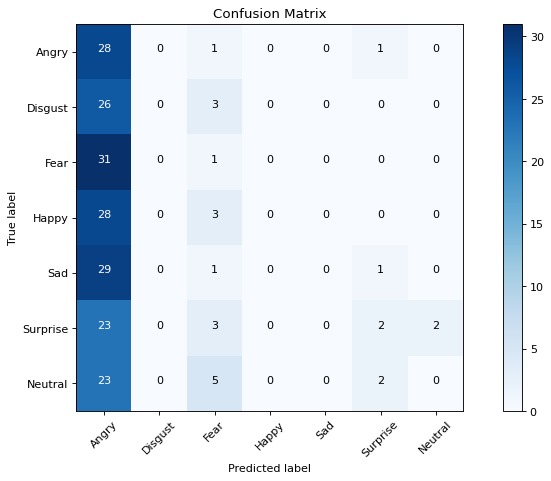

In [14]:
emotionsList = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

cm = confusion_matrix(y_true=not_categorial_valid_y, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=emotionsList, title='Confusion Matrix')

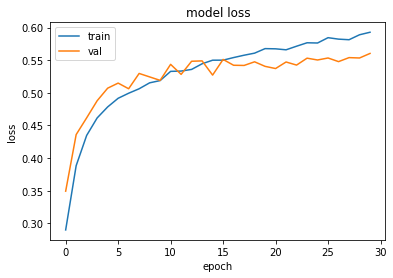

Trained Model not in memory


In [35]:
try:
    plt.plot(previous_history.accuracy)
    plt.plot(previous_history.val_accuracy)
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
except:
    print("Previous Model not loaded")

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
except:
    print("Trained Model not in memory")

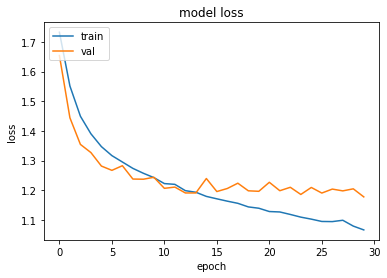

Trained Model not in memory


In [36]:
try:
    plt.plot(previous_history.loss)
    plt.plot(previous_history.val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
except:
    print("Previous Model not loaded")

try:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
except:
    print("Trained Model not in memory")

In [37]:
predicted = np.argmax(predictions, axis=1)
report = classification_report(np.argmax(valid_y, axis=1), predicted)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.39      0.44       467
           1       0.58      0.39      0.47        56
           2       0.46      0.17      0.24       496
           3       0.73      0.81      0.77       895
           4       0.43      0.46      0.44       653
           5       0.68      0.78      0.73       415
           6       0.45      0.61      0.52       607

    accuracy                           0.56      3589
   macro avg       0.55      0.52      0.52      3589
weighted avg       0.55      0.56      0.54      3589



In [5]:
selectedModel = "Model 1"

if selectedModel == "Model 1":
    classifier = load_model(r'Model1_JAFFEE.h5')
    labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
    
elif selectedModel == "Model 2":
    classifier = model_from_json(open("Model2.json", "r").read())
    classifier.load_weights('Model2_Weights.h5')
    labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
else:
    raise "No existing model selected"


faceDetector = cv2.CascadeClassifier(r'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while True:
    # Get frame from camera
    ret, frame = cap.read()
    # Convert to grayscale
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    # Detect the face
    faces = faceDetector.detectMultiScale(gray, 1.3, 5)
    
    # Iterate over the faces (bounding boxes)
    for (x, y, w, h) in faces:
        # Draw the rectangle bounding box of face
        cv2.rectangle(frame, (x,y), (x+w, y+h),(255,0,0), 2)
        croppedFace = gray[y:y+h, x:x+w]
        # Resize the face to the size the classifier expects (48 x 48)
        croppedFace = cv2.resize(croppedFace, (48,48), interpolation=cv2.INTER_AREA)

        # If a face has been detected and the image has pixel values
        if np.sum([croppedFace]) != 0:
            roi = croppedFace.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)

            preds = classifier.predict(roi)[0]
            label=labels[preds.argmax()]
            label_position = (20,60)

            cv2.putText(img=frame, text=label, org=label_position,
                fontFace=cv2.FONT_HERSHEY_COMPLEX , fontScale=2, color=[255, 0, 0], lineType=cv2.LINE_AA, thickness=3)
        else:
            cv2.putText(frame,'No Face Detected',(20,60),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),2)
            
    cv2.imshow('Facial Expression Detector', frame)
    
    # If the q letter is pressed then exit the program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()